In [148]:
%matplotlib inline
import matplotlib.pyplot as plt
import requests
import time
import html5lib
import pandas as pd
import numpy as np
import pickle
import BeautifulSoup as soup
from ipy_progressbar import ProgressBar
from IPython.display import HTML
import os
import us
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.gridspec import GridSpec
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from scipy.stats.stats import pearsonr


In [29]:
st_states = {}
fname = 'us-states.json'
if not(os.path.isfile(fname)):
    print('Retreiving data')
    url = "https://raw.githubusercontent.com/alignedleft/d3-book/master/chapter_12/us-states.json"
    r = requests.get(url)
    f = open(fname, 'w')
    f.write(r.text)
    f.flush()
    f.close()

abbrev_dict = {}
state_json = json.load(open(fname, 'r'))
for state in us.states.STATES:
    abbrev_dict[state.name.upper()] = state.abbr
for feat in state_json['features']:
    x = 0
    st = feat['properties']['name'].upper()
    try:
        abbrev = abbrev_dict[st]
        geom = feat['geometry']
        st_states[abbrev] = geom
    except KeyError:
        continue

In [10]:
df = pd.read_csv('county_level_clean.csv', sep='\t')

In [123]:
df2 = pd.DataFrame(df.groupby(['state'])['reports'].sum())
df2.reset_index(inplace=True)

In [124]:
df2['c'] = df2['reports'] / df2['reports'].sum()

ca-al
ca-bc
ca-mn
ca-nb
ca-on
ca-qu
ca-sk
ca-yu


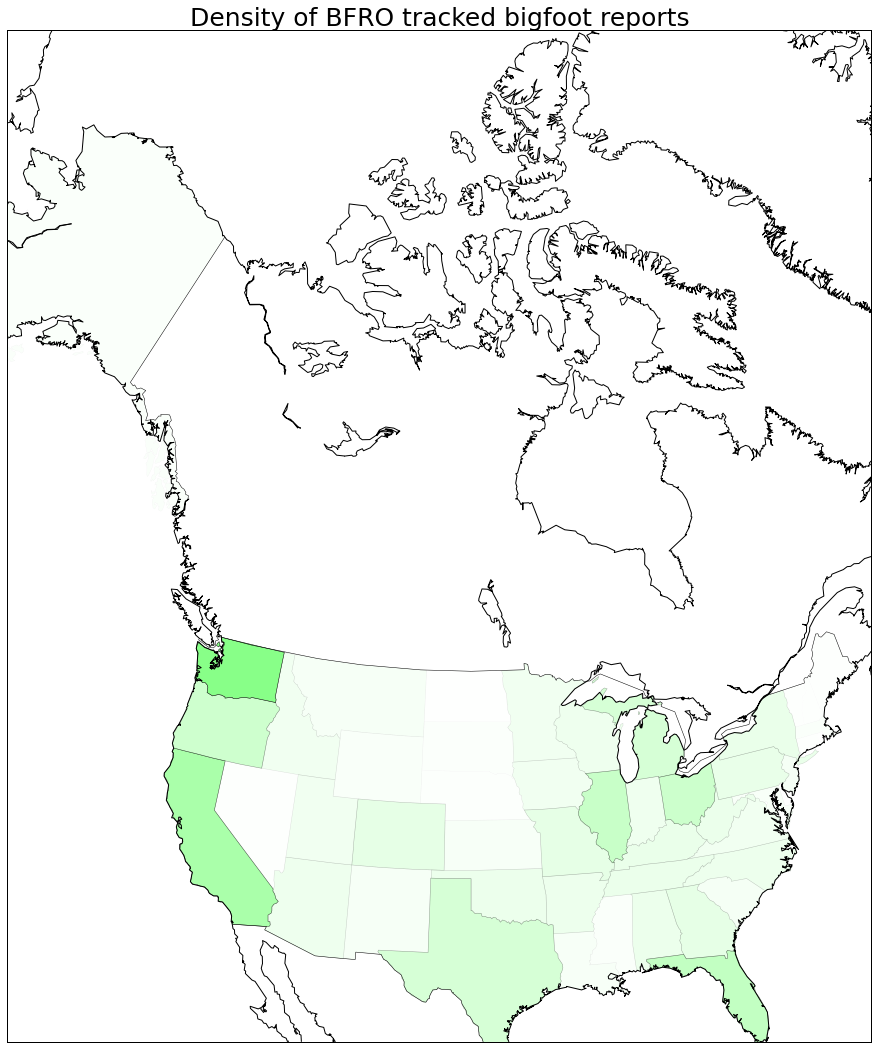

In [79]:
def plot_map(df, col, title):
    fig = plt.figure(figsize=(15,20))
    ax = fig.add_axes([0.1,0.1,0.8,0.8])
    lat_0=35
    m = Basemap(projection='stere',lon_0=-100,lat_0=35.,lat_ts=lat_0,\
                llcrnrlat=23,urcrnrlat=70,\
                llcrnrlon=-130,urcrnrlon=-20.5,\
                rsphere=6371200.,resolution='l',area_thresh=10000)
    m.drawcoastlines()
    m.drawcountries()
    m.drawmapboundary()
    plt.title(title, fontsize=25)
    mm = max(df[col])
    for ab in df['state']:
        try:
            geom = st_states[ab.upper()]
            tp = geom['type']
            if tp == 'Polygon':
                coords = []
                coords.append(geom['coordinates'])
            elif tp == 'MultiPolygon':
                coords = geom['coordinates']
            for shapel in coords:
                for shape in shapel:
                    lons = map(lambda x: x[0], shape)
                    lats = map(lambda x: x[1], shape)
                    x, y = m(lons, lats)
                    xy = zip(x, y)
                    a = df.ix[df.state == ab, col].tolist()[0] / mm
                    cc = '#88ff88'
                    poly = Polygon(xy, facecolor=cc, edgecolor='black', alpha=a)
                    ax.add_patch(poly)
        except KeyError:
            print ab
    plt.show()

plot_map(df2, 'c', 'Density of BFRO tracked bigfoot reports')

In [137]:
df3 = pd.read_csv('pop_data.csv', sep='\t')

In [138]:
# Note, this is a sloppy way to implement this, don't copy me here
abbrevs = []
for i in range(df3.shape[0]):
    row = df3.iloc[i]
    if type(row.abbrev) is str:
        abbrevs.append(row.abbrev)
    else:
        try:
            ab = abbrev_dict[row.state.upper()]
            abbrevs.append(ab)
        except KeyError:
            abbrevs.append('')

df3['abbrev'] = abbrevs

In [139]:
df3.head()

,state,pop_per_km_2,perc_pop,abbrev,cpop
0,New Jersey,1947.462334,0.027800,NJ,318900000
1,Rhode Island,1636.859714,0.003285,RI,318900000
2,Massachusetts,1380.813720,0.020907,MA,318900000
3,Connecticut,1195.095884,0.011234,CT,318900000
4,Maryland,982.823938,0.018521,MD,318900000


In [140]:
df2.head()

,state,reports,c
0,AK,21,0.004152
1,AL,94,0.018584
2,AR,89,0.017596
3,AZ,82,0.016212
4,CA,425,0.084025


In [141]:
df2['state'] = df2['state'].apply(str.upper)
df3['abbrev'] = df3['abbrev'].apply(lambda x: str(x).encode('ascii', 'replace').upper())

In [143]:
df4 = df3.merge(df2, left_on='abbrev', right_on='state')

(-0.011687619350311141, 0.93123780946382695)


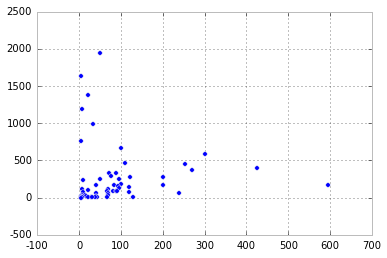

In [150]:
df4['den'] = df4['reports'] / df4['pop_per_km_2']
print pearsonr(df4['reports'].tolist(), df4['pop_per_km_2'].tolist())
plt.scatter(df4['reports'], df4['pop_per_km_2'])
plt.show()

In [151]:
df4.sort('den', ascending=False)

,state_x,pop_per_km_2,perc_pop,abbrev,cpop,state_y,reports,c,den
56,Yukon,0.100000,0.001000,CA-YU,35160000,CA-YU,5,0.000989,50.000000
51,British Columbia,4.800000,0.130000,CA-BC,35160000,CA-BC,130,0.025702,27.083333
53,Manitoba,2.200000,0.036000,CA-MN,35160000,CA-MN,31,0.006129,14.090909
48,Alaska,2.092142,0.002296,AK,318900000,AK,21,0.004152,10.037560
52,Alberta,5.700000,0.114000,CA-AL,35160000,CA-AL,38,0.007513,6.666667
49,Ontario,14.100000,0.385000,CA-ON,35160000,CA-ON,67,0.013246,4.751773
54,Saskatchewan,1.800000,0.032000,CA-SK,35160000,CA-SK,7,0.001384,3.888889
46,Montana,11.265380,0.003171,MT,318900000,MT,43,0.008501,3.817004
37,Oregon,65.822006,0.012277,OR,318900000,OR,240,0.047450,3.646197
23,Washington,168.819766,0.021778,WA,318900000,WA,594,0.117438,3.518545


In [ ]:
plot_map(df4, 'den', 'BFRO reported sightings by population density')

In [152]:
sum(df4['cpop']==318900000)

49

In [142]:
df4

,state_x,pop_per_km_2,perc_pop,abbrev,cpop,state_y,reports,c
0,New Jersey,1947.462334,0.027800,NJ,318900000,NJ,49,0.009688
1,Rhode Island,1636.859714,0.003285,RI,318900000,RI,5,0.000989
2,Massachusetts,1380.813720,0.020907,MA,318900000,MA,21,0.004152
3,Connecticut,1195.095884,0.011234,CT,318900000,CT,8,0.001582
4,Maryland,982.823938,0.018521,MD,318900000,MD,34,0.006722
5,Delaware,764.597434,0.002892,DE,318900000,DE,5,0.000989
6,New York,671.094780,0.061387,NY,318900000,NY,100,0.019771
7,Florida,586.765364,0.061080,FL,318900000,FL,302,0.059707
8,Pennsylvania,459.466570,0.039903,PA,318900000,PA,109,0.021550
9,Ohio,455.765088,0.036145,OH,318900000,OH,254,0.050217
